### Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
import plotly.express as px
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import t
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, classification_report as cls_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import warnings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TOM_FILES_DIR = "/content/drive/My Drive/Colab Notebooks/data science- transportation research/"
MAX_FILES_DIR = "/content/drive/My Drive/data science- transportation research/"
FILES_DIR = MAX_FILES_DIR

Mounted at /content/drive


In [ ]:
df  =  pd.read_csv(f"{FILES_DIR}collisions_and_streets.csv")

### Find Streets with Significant Deacrease In Collisions

In [ ]:
old_df = df[df['YEAR'].between(2013, 2015)]
new_df = df[df['YEAR'].between(2020, 2022)]

In [ ]:
def get_relevant_streets(new_df,old_df):
  grouped_data = old_df.groupby('ST_INDEX')['AMOUNT_ST_INDEX_YEAR_MONTH'].agg(['mean', 'var']).reset_index()
  old_mean_var_data = grouped_data.rename(columns={'mean': 'Mean_Collisions', 'var': 'Variance_Collisios'})
  old_mean_var_data_not_zero = old_mean_var_data[old_mean_var_data['Mean_Collisions'] != 0]
  grouped_data = new_df.groupby('ST_INDEX')['AMOUNT_ST_INDEX_YEAR_MONTH'].agg(['mean', 'var']).reset_index()
  new_mean_var_data = grouped_data.rename(columns={'mean': 'Mean_Collisions', 'var': 'Variance_Collisios'})
  new_mean_var_data_not_zero = new_mean_var_data[new_mean_var_data['Mean_Collisions'] != 0]
  st_index_values_new = new_mean_var_data_not_zero['ST_INDEX'].unique()
  st_index_values_old = old_mean_var_data_not_zero['ST_INDEX'].unique()
  return np.intersect1d(st_index_values_new,st_index_values_old)

In [ ]:
def paired_t_test_for_street(group,alpha=0.05):
  data_2017_2019 = group[group['YEAR'].between(2020, 2022)]['AMOUNT_ST_INDEX_YEAR_MONTH'].values
  data_2013_2015 = group[group['YEAR'].between(2013, 2015)]['AMOUNT_ST_INDEX_YEAR_MONTH'].values
  t_statistic, p_value = stats.ttest_rel(data_2017_2019, data_2013_2015, alternative='less')
  return p_value

def identify_significant_decrease_streets(new_df, old_df,correction_method='bonferroni',alpha=0.05):
    all_data = pd.concat([new_df, old_df])
    p_values = all_data.groupby('ST_INDEX').apply(paired_t_test_for_street)

    # Perform multiple hypothesis testing correction
    if correction_method == 'bh':
        _, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    else:
        _, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

    corrected_p_values = pd.Series(corrected_p_values, index=p_values.index)
    # Get the street indices (STREET) where the corrected p-value is below the significance level
    significant_streets = corrected_p_values[corrected_p_values < alpha].reset_index()['ST_INDEX'].tolist()

    return significant_streets

In [ ]:
def calculate_power(sample_size, true_effect_size, alpha_bonferroni):
    power_analysis = TTestIndPower()
    return power_analysis.solve_power(effect_size=true_effect_size, nobs1=sample_size, alpha=alpha_bonferroni, alternative='smaller')

In [ ]:
relevant_streets = get_relevant_streets(new_df,old_df)
new_df_only_rev_st = new_df[np.isin(new_df['ST_INDEX'], relevant_streets)]
old_df_only_rev_st = old_df[np.isin(new_df['ST_INDEX'], relevant_streets)]

In [ ]:
#significant_streets = identify_significant_decrease_streets(new_df_only_rev_st, old_df_only_rev_st,correction_method='bh')
significant_streets = identify_significant_decrease_streets(new_df_only_rev_st, old_df_only_rev_st)
print("Number of Streets with statistically significant decrease in collisions:", len(significant_streets))

Number of Streets with statistically significant decrease in collisions: 1644


In [ ]:
# Calculate the power of the paired t-test
differences = new_df_only_rev_st.groupby('ST_INDEX')['AMOUNT_ST_INDEX_YEAR_MONTH'].mean() - old_df_only_rev_st.groupby('ST_INDEX')['AMOUNT_ST_INDEX_YEAR_MONTH'].mean()
effect_size = differences.mean()/differences.std()
sample_size =  len(relevant_streets)
alpha_bonferroni = 0.05 / len(relevant_streets)  # Bonferroni-adjusted alpha
power = calculate_power(sample_size, effect_size, alpha_bonferroni)
print("The power of the paired t-test after Bonferroni correction:", power)

The power of the paired t-test after Bonferroni correction: 1.0


### Read Main Data

In [ ]:
def filter_rows(chunk):
    #return chunk[(chunk['ST_INDEX'].isin(objective_streets.index)) & ((chunk['YEAR'] == 2022) | (chunk['YEAR'] == 2013))]
    return chunk[chunk['YEAR'] == 2022]


# Define the chunk size
chunk_size = 1000

# Initialize an empty list to store the filtered chunks
filtered_chunks = []

# Read the CSV file in chunks and filter each chunk
for chunk in pd.read_csv(f"{FILES_DIR}data_to_models.csv", chunksize=chunk_size):
    filtered_chunk = filter_rows(chunk)
    filtered_chunks.append(filtered_chunk)

# Concatenate the filtered chunks into the final DataFrame
df_filtered = pd.concat(filtered_chunks)
#df_filtered['IS_SIGNED'] = pd.to_numeric(df_filtered['IS_SIGNED'], errors='coerce', downcast='integer')
#df_filtered = df_filtered.fillna(0)

### Logistic Regression With Significant Streets As Labels

In [ ]:
df_filtered['significant'] = df_filtered['ST_INDEX'].isin(significant_streets).astype(bool)

In [ ]:
aggregated_df = df_filtered.groupby('ST_INDEX').agg({
    'SUMMONS': 'sum',
    'PEDESTRIAN_BINARY': 'max',
    'INTERSECTIONS_BINARY': 'max',
    'TURN_TRAFFIC_BINARY': 'max',
    'HUMPS': 'max',
    'IS_SIGNED': 'max',
    'SPEED_LIMIT': 'max',
    'COLLISIONS': 'sum',
    'significant' : 'max'
}).reset_index()

In [ ]:
aggregated_df

,ST_INDEX,SUMMONS,PEDESTRIAN_BINARY,INTERSECTIONS_BINARY,TURN_TRAFFIC_BINARY,HUMPS,IS_SIGNED,SPEED_LIMIT,COLLISIONS,significant
0,0,18.0,0,0,0,0.0,0,25.0,0.0,False
1,1,0.0,0,0,0,0.0,0,25.0,0.0,False
2,2,0.0,0,0,0,0.0,0,25.0,0.0,False
3,3,0.0,0,0,0,0.0,0,25.0,0.0,False
4,4,5.0,0,0,0,0.0,0,25.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...
121110,121110,0.0,0,0,0,0.0,1,30.0,0.0,False
121111,121111,0.0,0,0,0,0.0,1,25.0,0.0,False
121112,121112,0.0,0,0,0,0.0,1,35.0,0.0,False
121113,121113,0.0,1,0,0,0.0,1,25.0,0.0,False


In [ ]:
def get_groups_by_knn(df, col_name):
  exp_group_features = df[df[col_name] == 1]
  cont_group_features = df[df[col_name] == 0]
  n_neighbors = 1
  knn = NearestNeighbors(n_neighbors=n_neighbors)
  knn.fit(cont_group_features)
  distances, indices = knn.kneighbors(exp_group_features)
  groups = df[col_name]
  groups[cont_group_features.index[indices.flatten()]] = 2
  mapping = {0: "nither", 1: "experiment", 2: "control"}
  groups = groups.astype(int).replace(mapping)
  return groups

In [ ]:
aggregated_df['significant'].value_counts()

False    119471
True       1644
Name: significant, dtype: int64

In [ ]:
groups = get_groups_by_knn(aggregated_df.copy(),'significant')
groups.value_counts()

<ipython-input-18-0ccd41f387f5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups[cont_group_features.index[indices.flatten()]] = 2


nither        117996
experiment      1644
control         1475
Name: significant, dtype: int64

In [ ]:
control_experiment_df = aggregated_df[groups.isin(['experiment', 'control'])]

In [ ]:
control_experiment_df

,ST_INDEX,SUMMONS,PEDESTRIAN_BINARY,INTERSECTIONS_BINARY,TURN_TRAFFIC_BINARY,HUMPS,IS_SIGNED,SPEED_LIMIT,COLLISIONS,significant
21,21,1.0,0,0,0,0.0,0,25.0,0.0,True
23,23,0.0,0,0,0,0.0,0,25.0,0.0,False
24,24,0.0,0,0,0,0.0,0,25.0,1.0,True
27,27,2.0,0,0,0,0.0,0,25.0,3.0,False
28,28,8.0,0,0,0,0.0,0,25.0,9.0,True
...,...,...,...,...,...,...,...,...,...,...
120827,120827,134.0,0,0,0,1.0,1,40.0,7.0,False
120835,120835,3437.0,1,0,0,0.0,1,25.0,0.0,True
120888,120888,128.0,0,0,0,0.0,1,25.0,0.0,True
120943,120943,0.0,0,0,0,0.0,1,25.0,2.0,False


In [ ]:
features = control_experiment_df.iloc[:, 1:-2]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, control_experiment_df['significant'], test_size=0.25, random_state=42)
# TODO add gridSerach/CV for Regularization
logreg = LogisticRegression(C=0.001)
result = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report = cls_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report)

Accuracy: 0.5551282051282052
Confusion Matrix:
 [[  3 342]
 [  5 430]]
Classification Report:
               precision    recall  f1-score   support

       False       0.38      0.01      0.02       345
        True       0.56      0.99      0.71       435

    accuracy                           0.56       780
   macro avg       0.47      0.50      0.36       780
weighted avg       0.48      0.56      0.40       780



In [ ]:
coefficients = logreg.coef_
intercept = logreg.intercept_

# Display the coefficients and intercept
print("Coefficients:", coefficients)

Coefficients: [[ 0.0393355   0.02883574 -0.00583046  0.03033097  0.0148997   0.02106401
  -0.01496309]]


AUC: 0.4986006996501749


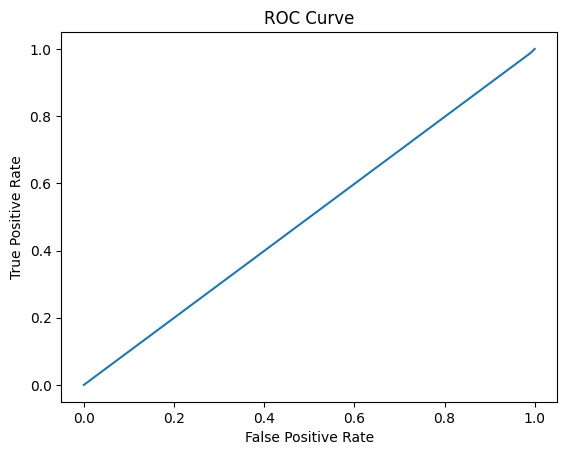

In [ ]:
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

plt.show()

In [ ]:
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Display the summary of the model
#print(result.summary())
feature_names = list(features.columns)

# Create a custom summary table
summary_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.round(result.params[1:],2),  # Exclude the intercept coefficient
    'P-value': np.round(result.pvalues[1:],2),      # Exclude the intercept p-value
    # Add other statistics if needed
})

# Display the custom summary table
print(summary_table)





Optimization terminated successfully.
         Current function value: 0.688592
         Iterations 5
                 Feature  Coefficient  P-value
x1               SUMMONS         0.13     0.01
x2     PEDESTRIAN_BINARY         0.06     0.23
x3  INTERSECTIONS_BINARY        -0.03     0.45
x4   TURN_TRAFFIC_BINARY         0.07     0.11
x5                 HUMPS         0.04     0.46
x6             IS_SIGNED         0.05     0.29
x7           SPEED_LIMIT        -0.05     0.26


In [ ]:
summary_table["P-value"][0]

0.01

In [ ]:
i = 0
for feature in ["SUMMONS","PEDESTRIAN_BINARY", "INTERSECTIONS_BINARY","TURN_TRAFFIC_BINARY", "HUMPS", "IS_SIGNED", "SPEED_LIMIT"]:
  print(f"{feature} & {summary_table.Coefficient[i]} & {summary_table['P-value'][i]}\\\\")
  i+=1
  print("\hline")

SUMMONS & 0.13 & 0.01\\
\hline
PEDESTRIAN_BINARY & 0.06 & 0.23\\
\hline
INTERSECTIONS_BINARY & -0.03 & 0.45\\
\hline
TURN_TRAFFIC_BINARY & 0.07 & 0.11\\
\hline
HUMPS & 0.04 & 0.46\\
\hline
IS_SIGNED & 0.05 & 0.29\\
\hline
SPEED_LIMIT & -0.05 & 0.26\\
\hline


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 7: Create and train the logistic regression model on the resampled data
logreg_model = LogisticRegression()
logreg_model.fit(X_train_resampled, y_train_resampled)

# Step 8: Make predictions on the test set and evaluate the model
y_pred = logreg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report = cls_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report)

Accuracy: 0.5038461538461538
Confusion Matrix:
 [[244 101]
 [286 149]]
Classification Report:
               precision    recall  f1-score   support

       False       0.46      0.71      0.56       345
        True       0.60      0.34      0.44       435

    accuracy                           0.50       780
   macro avg       0.53      0.52      0.50       780
weighted avg       0.54      0.50      0.49       780



### Permutation Test On The Features Of The Significant Streets

In [ ]:
aggregated_df = df_filtered.groupby('ST_INDEX').agg({
    'SUMMONS': 'sum',
    'PEDESTRIAN_BINARY': 'max',
    'INTERSECTIONS_BINARY': 'max',
    'TURN_TRAFFIC_BINARY': 'max',
    'HUMPS': 'max',
    'IS_SIGNED': 'max',
    'SPEED_LIMIT': 'max',
    'COLLISIONS': 'sum'
}).reset_index()

In [ ]:
aggregated_df

,ST_INDEX,SUMMONS,PEDESTRIAN_BINARY,INTERSECTIONS_BINARY,TURN_TRAFFIC_BINARY,HUMPS,IS_SIGNED,SPEED_LIMIT,COLLISIONS
0,0,18.0,0,0,0,0.0,0,25.0,0.0
1,1,0.0,0,0,0,0.0,0,25.0,0.0
2,2,0.0,0,0,0,0.0,0,25.0,0.0
3,3,0.0,0,0,0,0.0,0,25.0,0.0
4,4,5.0,0,0,0,0.0,0,25.0,2.0
...,...,...,...,...,...,...,...,...,...
121110,121110,0.0,0,0,0,0.0,1,30.0,0.0
121111,121111,0.0,0,0,0,0.0,1,25.0,0.0
121112,121112,0.0,0,0,0,0.0,1,35.0,0.0
121113,121113,0.0,1,0,0,0.0,1,25.0,0.0


In [ ]:
df_last_month = df_filtered[df_filtered['MONTH'] == 12]

In [ ]:
if set( df_last_month[df_last_month['ST_INDEX'].isin(significant_streets)]['ST_INDEX'].unique()) == set(significant_streets):
    print("df_filtered contains only the streets in desired_st_indices.")
else:
    print("df_filtered does not contain only the streets in desired_st_indices.")

df_filtered contains only the streets in desired_st_indices.


In [ ]:
def permutation_test_mean(x_1,x_2,num_perms):
    T = np.abs(np.mean(x_1)-np.mean(x_2))
    print(f"The diff in mean is: {T}")
    m_1 = len(x_1)
    m_2 = len(x_2)
    T_perm = np.zeros(num_perms)
    X = np.concatenate((x_1,x_2))
    for j in range(num_perms):
        idx = np.random.permutation(len(X))
        T_perm[j] = np.abs(np.mean(X[idx[:m_1]])-np.mean(X[idx[(m_2+1):]]))
    p_perm = len(np.where(T_perm>T)[0])/num_perms
    return p_perm

In [ ]:
def permutation_test_median(x_1,x_2,num_perms):
    T = np.abs(np.median(x_1)-np.median(x_2))
    print(f"The diff in median is: {T}")
    m_1 = len(x_1)
    m_2 = len(x_2)
    T_perm = np.zeros(num_perms)
    X = np.concatenate((x_1,x_2))
    for j in range(num_perms):
        idx = np.random.permutation(len(X))
        T_perm[j] = np.abs(np.median(X[idx[:m_1]])-np.median(X[idx[(m_2+1):]]))
    p_perm = len(np.where(T_perm>T)[0])/num_perms
    return p_perm

In [ ]:
df_last_month.iloc[:,6:]

,Education,Cultural,Recreational,Social Services,Transportation,Commercial,Government,Religious Institution,Health Services,Public Safety,...,U-Turn,FerryRoute,lat,long,Manhattan,Bronx,Brooklyn,Queens,Staten Island,significant
131,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-74.017773,40.706518,1,0,0,0,0,False
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-74.017347,40.707151,1,0,0,0,0,False
399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-74.016873,40.707798,1,0,0,0,0,False
533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-74.016994,40.704825,1,0,0,0,0,False
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-74.014634,40.704637,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16228871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-73.862739,40.575841,0,0,0,1,0,False
16229005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-73.994906,40.715776,1,0,0,0,0,False
16229139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-73.995294,40.715635,1,0,0,0,0,False
16229273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-73.955633,40.799306,1,0,0,0,0,False


In [ ]:
m = aggregated_df.iloc[:, 1:].shape[1]
p_val_vec = np.zeros(m)
X_C = aggregated_df[~aggregated_df['ST_INDEX'].isin(significant_streets)].sample(n=len(significant_streets), random_state=42).iloc[:, 1:]
X_E = aggregated_df[aggregated_df['ST_INDEX'].isin(significant_streets)].iloc[:, 1:]
for i in range(m):
    print(f"Feature: {aggregated_df.iloc[:, 1:].columns[i]}")
    p_val_vec[i] = permutation_test_mean(X_C.iloc[:,i],X_E.iloc[:,i], 12000)


Feature: SUMMONS
The diff in mean is: 60.592457420924575
Feature: PEDESTRIAN_BINARY
The diff in mean is: 0.09793187347931873
Feature: INTERSECTIONS_BINARY
The diff in mean is: 0.004257907542579075
Feature: TURN_TRAFFIC_BINARY
The diff in mean is: 0.037104622871046225
Feature: HUMPS
The diff in mean is: 0.00182481751824818
Feature: IS_SIGNED
The diff in mean is: 0.062043795620437964
Feature: SPEED_LIMIT
The diff in mean is: 0.11253041362530425
Feature: COLLISIONS
The diff in mean is: 2.769464720194647


In [ ]:
i=0
for feature in ["SUMMONS","PEDESTRIAN_BINARY", "INTERSECTIONS_BINARY","TURN_TRAFFIC_BINARY", "HUMPS", "IS_SIGNED", "SPEED_LIMIT"]:
  print(f"{feature} & {p_val_vec[i]}\\\\")
  i+=1
  print("\hline")

SUMMONS & 0.0\\
\hline
PEDESTRIAN_BINARY & 0.0\\
\hline
INTERSECTIONS_BINARY & 0.02\\
\hline
TURN_TRAFFIC_BINARY & 0.0\\
\hline
HUMPS & 0.8459166666666667\\
\hline
IS_SIGNED & 0.0\\
\hline
SPEED_LIMIT & 0.39216666666666666\\
\hline


In [ ]:
np.round(p_val_vec,3)

array([0.   , 0.   , 0.02 , 0.   , 0.846, 0.   , 0.392, 0.   ])

In [ ]:
fig = px.histogram(p_val_vec, nbins=10)
fig.show()

### PCA

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform((df_last_month.iloc[:,19:26]).T)
x_comp_all = pca.components_[0]
y_comp_all = pca.components_[1]
fig = px.scatter(x=x_comp_all[::1], y=y_comp_all[::1], color = (~df_last_month['ST_INDEX'].isin(significant_streets))[::1], title="PCA of All Features", labels={"color":"Humps chaged"})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_last_month_only_sig_st = df_last_month[df_last_month['ST_INDEX'].isin(significant_streets)]

In [ ]:
#PCA only the Significant_streets
pca = PCA(n_components=3)
X_pca = pca.fit_transform((df_last_month_only_sig_st.iloc[:,19:26]).T)
x_comp_all = pca.components_[0]
y_comp_all = pca.components_[1]
fig = px.scatter(x=x_comp_all[::1], y=y_comp_all[::1], color = (~df_last_month_only_sig_st['ST_INDEX'].isin(significant_streets))[::1], title="PCA of All Features only on significant streets", labels={"color":"Humps chaged"})
fig.show()

### PLAYGROUND

In [ ]:
def calculate_precentile(df):
  total_collisions = df.groupby('ST_INDEX')['COLLISIONS'].sum().reset_index()
  # Calculate the percentile place based on total collisions, excluding the street itself
  total_collisions['Percentile'] = total_collisions['COLLISIONS'].apply(lambda x: percentileofscore(total_collisions['COLLISIONS'], x,kind='weak'))
  total_collisions = total_collisions.rename(columns={'COLLISIONS': 'Total_Collisions'})
  in_percentile = total_collisions['Percentile'].min()
  max_percentile = total_collisions['Percentile'].max()
  total_collisions['Normalized_Percentile'] = 1 + (total_collisions['Percentile'] - min_percentile) * 9 / (max_percentile - min_percentile)
  total_collisions['Normalized_Percentile'] = total_collisions['Normalized_Percentile'].round()
  return total_collisions[['ST_INDEX','Normalized_Percentile']]

In [ ]:
min_percentile = total_collisions['Percentile'].min()
max_percentile = total_collisions['Percentile'].max()
total_collisions['Normalized_Percentile'] = 1 + (total_collisions['Percentile'] - min_percentile) * 9 / (max_percentile - min_percentile)
total_collisions['Normalized_Percentile'] = total_collisions['Normalized_Percentile'].round()
# Display the normalized percentiles
print(total_collisions)

        ST_INDEX  Total_Collisions  Percentile  Normalized_Percentile
0              0              12.0   90.221690                    7.0
1              1               0.0   70.131693                    1.0
2              2               0.0   70.131693                    1.0
3              3               0.0   70.131693                    1.0
4              4              17.0   92.875366                    8.0
...          ...               ...         ...                    ...
121110    121110               0.0   70.131693                    1.0
121111    121111               0.0   70.131693                    1.0
121112    121112               0.0   70.131693                    1.0
121113    121113               0.0   70.131693                    1.0
121114    121114               0.0   70.131693                    1.0

[121115 rows x 4 columns]


In [ ]:
df_2013_2015_with_prcentiles['Normalized_Percentile'].value_counts()

1.0     254820
3.0      20355
4.0      17274
5.0      15567
7.0      12750
8.0      12717
9.0      12360
6.0      11451
10.0      6051
Name: Normalized_Percentile, dtype: int64

In [ ]:
df_2013_2015_with_prcentiles = pd.merge(df_2013_2015, total_collisions, on='ST_INDEX')
df_2013_2015_with_prcentiles

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS,Total_Collisions,Percentile,Normalized_Percentile
0,1,0,2013,8.0,12.0,90.221690,7.0
1,2,0,2014,3.0,12.0,90.221690,7.0
2,3,0,2015,1.0,12.0,90.221690,7.0
3,13,1,2013,0.0,0.0,70.131693,1.0
4,14,1,2014,0.0,0.0,70.131693,1.0
...,...,...,...,...,...,...,...
363340,1453358,121113,2014,0.0,0.0,70.131693,1.0
363341,1453359,121113,2015,0.0,0.0,70.131693,1.0
363342,1453369,121114,2013,0.0,0.0,70.131693,1.0
363343,1453370,121114,2014,0.0,0.0,70.131693,1.0


In [ ]:
df_2013_2015_with_prcentiles[df_2013_2015_with_prcentiles['Normalized_Percentile'] == 10]

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS,Total_Collisions,Percentile,Normalized_Percentile
60,241,20,2013,17.0,57.0,98.650043,10.0
61,242,20,2014,22.0,57.0,98.650043,10.0
62,243,20,2015,18.0,57.0,98.650043,10.0
84,337,28,2013,63.0,173.0,99.901746,10.0
85,338,28,2014,71.0,173.0,99.901746,10.0
...,...,...,...,...,...,...,...
362665,1450658,120888,2014,22.0,93.0,99.450109,10.0
362666,1450659,120888,2015,33.0,93.0,99.450109,10.0
362838,1451353,120946,2013,60.0,148.0,99.837345,10.0
362839,1451354,120946,2014,41.0,148.0,99.837345,10.0


### Exploration

<Axes: xlabel='YEAR', ylabel='Collisions'>

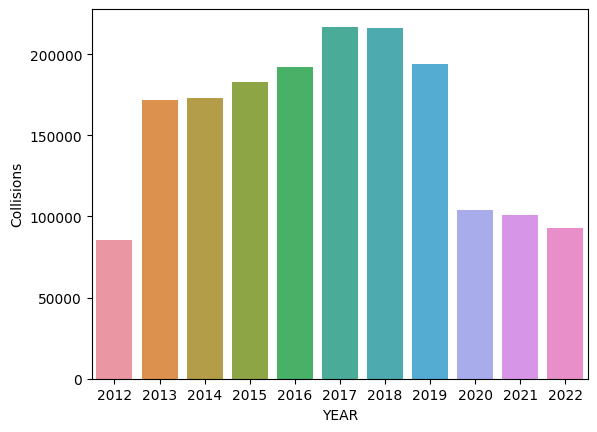

In [ ]:
coll_per_year = np.zeros(len(years))
for i,year in enumerate(years):
  coll_per_year[i]=(df[df['YEAR'] == year]['COLLISIONS'].sum())
data = {'YEAR': years, 'Collisions': coll_per_year}
total_collisons = pd.DataFrame(data)
sns.barplot(data=total_collisons, x='YEAR', y='Collisions')

<ipython-input-12-d21fc49f927e>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_not_zero['COLLISIONS'], bins=bins, kde=False)


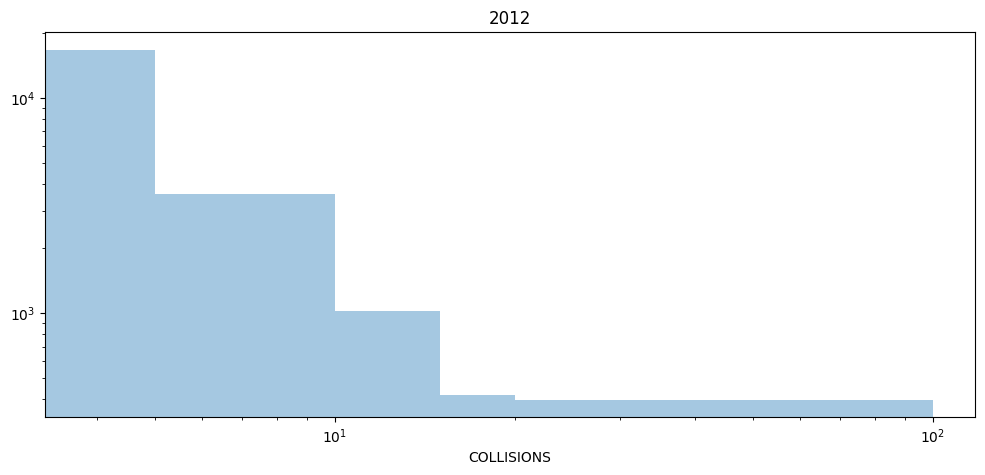

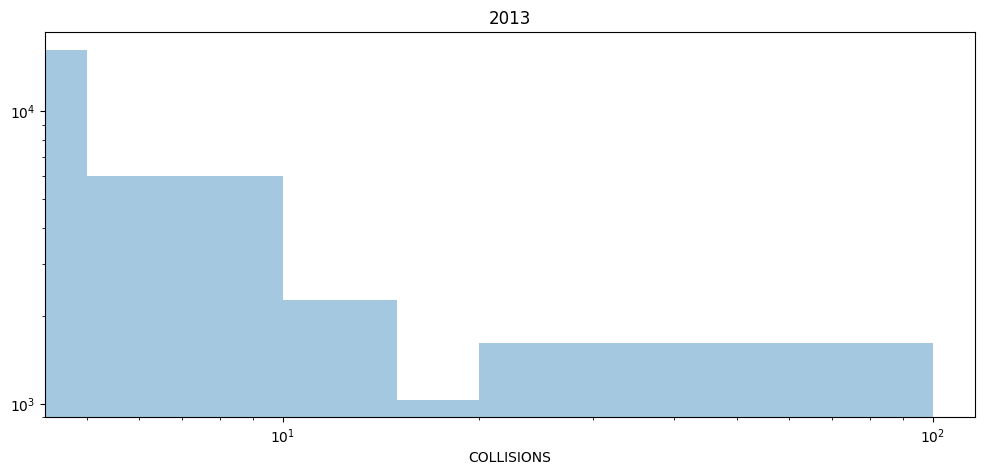

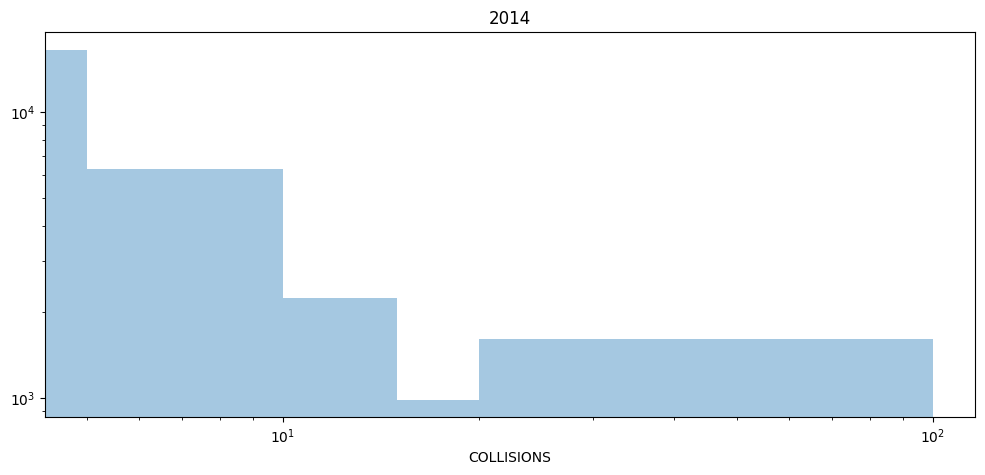

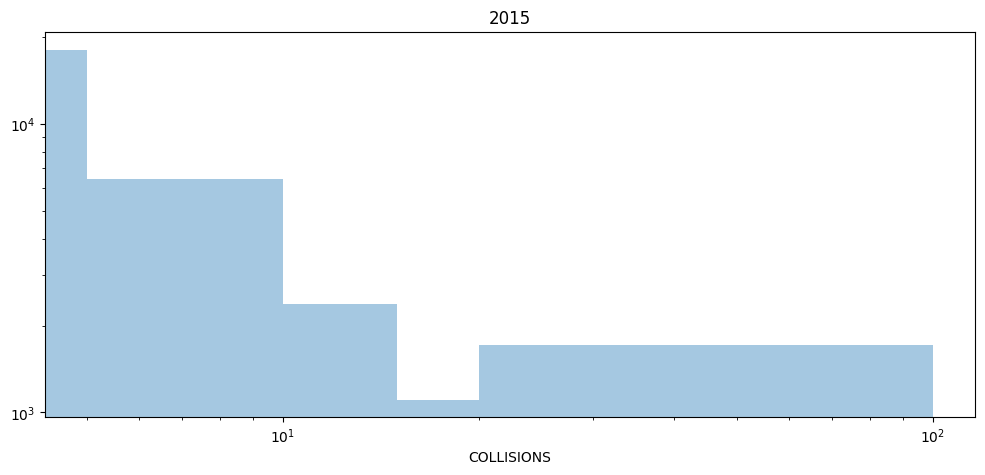

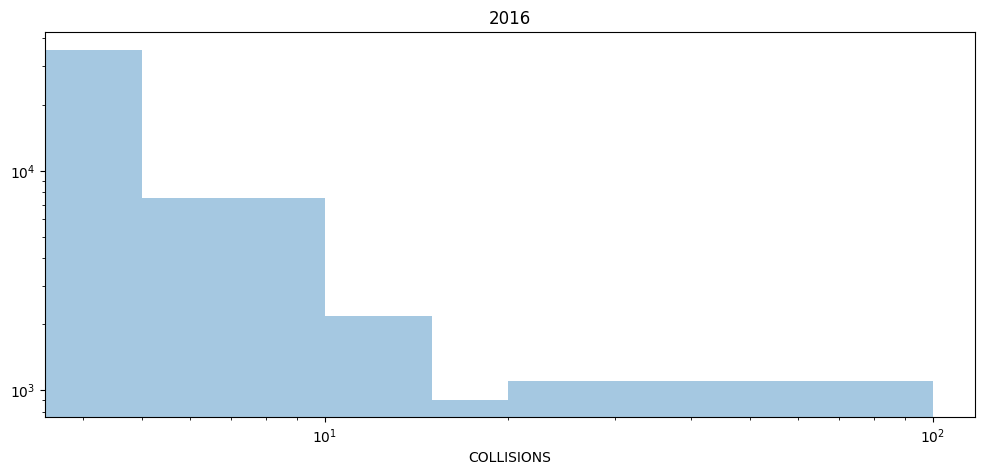

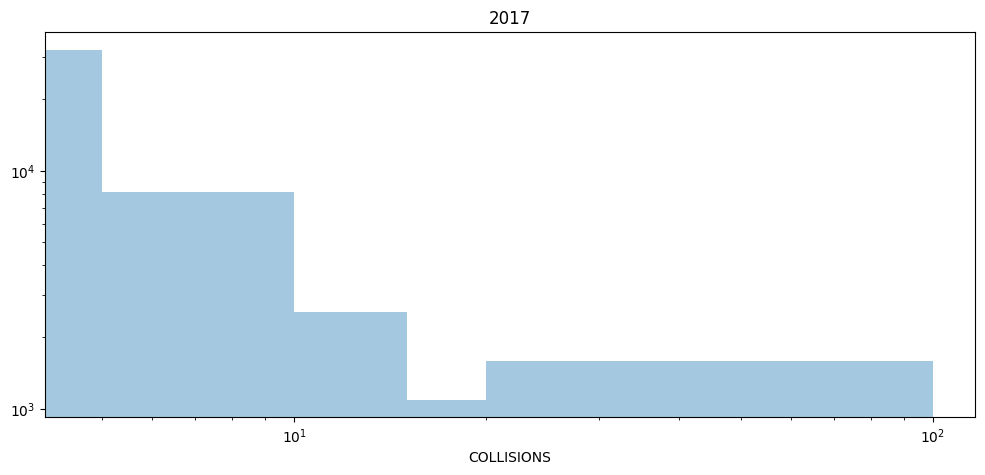

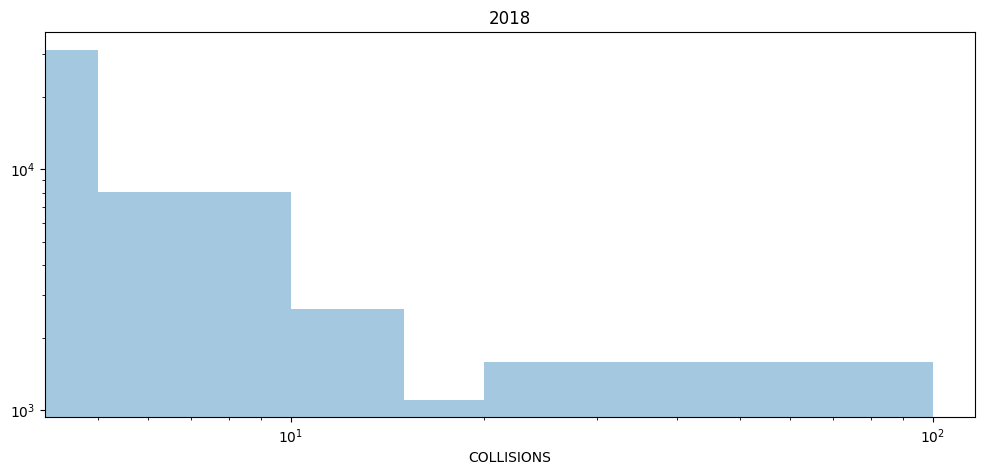

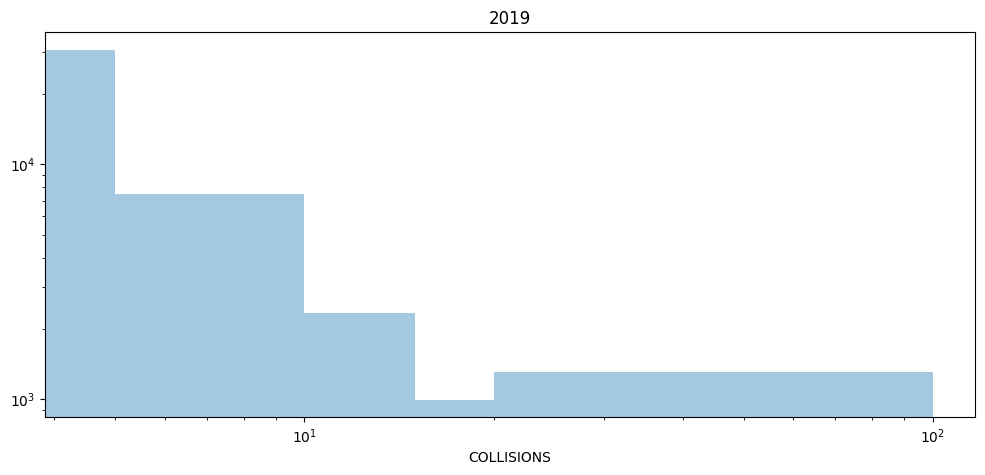

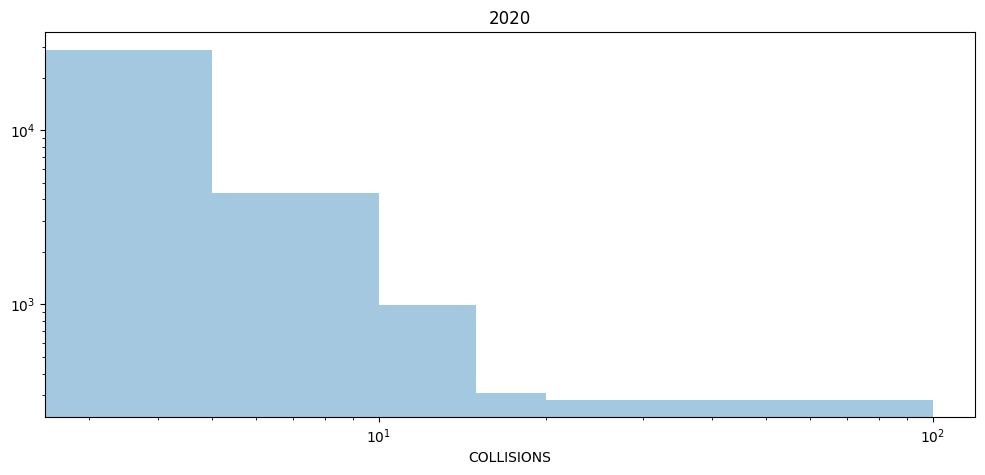

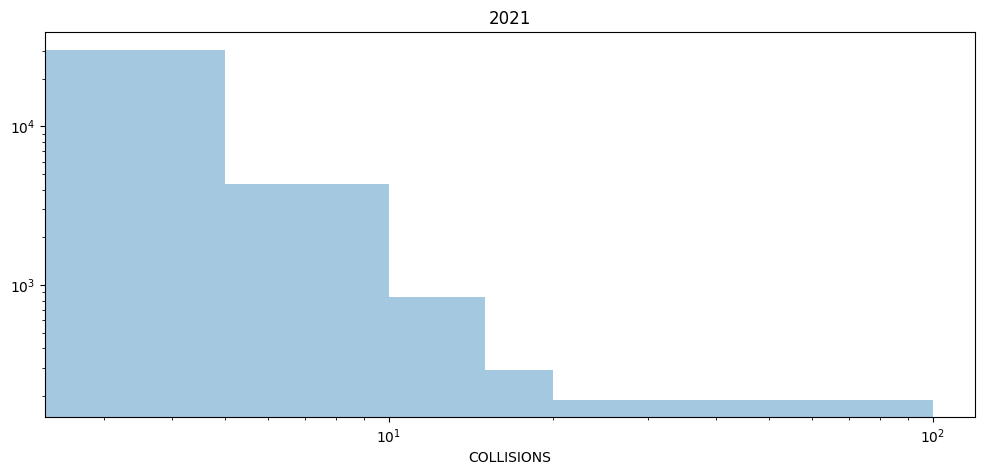

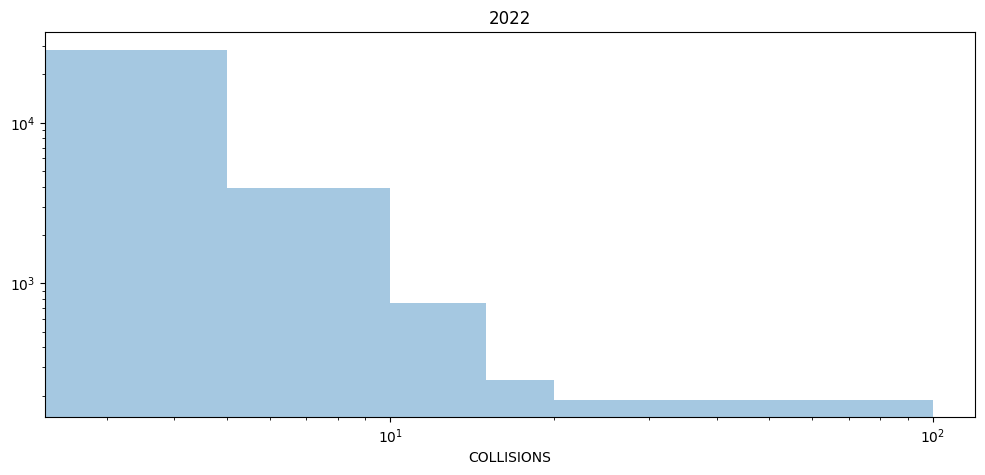

In [ ]:
bins = [0,5,10,15,20,100]  # Define the bin edges
for year in years:
  df_year = df[df['YEAR'] == year]
  df_not_zero = df_year[df_year['COLLISIONS'] > 0]
  plt.figure(figsize=(12,5))
  plt.title(year)
  sns.distplot(df_not_zero['COLLISIONS'], bins=bins, kde=False)
  plt.xscale('log')
  plt.yscale('log')


In [ ]:

df_2012 = df[df['YEAR'] == 2012]

In [ ]:
df_2013_90 = df[(df['YEAR'] == 2013) & (df['COLLISIONS'] >14)]

In [ ]:
df_2022_90 = df[(df['YEAR'] == 2022) & (df['COLLISIONS'] >14)]

In [ ]:
df_2013_90

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS
241,241,20,2013,17.0
253,253,21,2013,16.0
289,289,24,2013,18.0
337,337,28,2013,63.0
889,889,74,2013,44.0
...,...,...,...,...
1449193,1449193,120766,2013,15.0
1449553,1449553,120796,2013,18.0
1449649,1449649,120804,2013,23.0
1450657,1450657,120888,2013,38.0


 streets with big diff : 120766

In [ ]:
df_2013_90[df_2013_90['ST_INDEX'] == 120946]

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS
1451353,1451353,120946,2013,60.0


In [ ]:
df_2022_90

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS
3610,3610,300,2022,20.0
6286,6286,523,2022,16.0
9838,9838,819,2022,17.0
11494,11494,957,2022,18.0
11506,11506,958,2022,17.0
...,...,...,...,...
1439710,1439710,119975,2022,21.0
1439866,1439866,119988,2022,18.0
1441138,1441138,120094,2022,24.0
1445362,1445362,120446,2022,19.0


In [ ]:
df_2022_90[df_2022_90['ST_INDEX'] == 120946]

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS


In [ ]:
for year in years:
  print(f"Data for the Year: {year}")
  df_year = df[df['YEAR'] == year]
  df_year = df_year[df_year['COLLISIONS'] > 0]
  print(df_year['COLLISIONS'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]))
  print("*********************************************")


Data for the Year: 2012
count    22134.000000
mean         3.860938
std          4.928339
min          1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          2.000000
50%          2.000000
60%          3.000000
70%          4.000000
80%          5.000000
90%          8.000000
max         89.000000
Name: COLLISIONS, dtype: float64
*********************************************
Data for the Year: 2013
count    27217.000000
mean         6.317118
std          8.917114
min          1.000000
10%          1.000000
20%          1.000000
30%          2.000000
40%          3.000000
50%          3.000000
60%          5.000000
70%          6.000000
80%          9.000000
90%         14.000000
max        172.000000
Name: COLLISIONS, dtype: float64
*********************************************
Data for the Year: 2014
count    27667.000000
mean         6.243467
std          8.865804
min          1.000000
10%          1.000000
20%          1.000000
30%          2.000000


In [ ]:
df_2012['COLLISIONS'].describe()

count    121115.000000
mean          0.705594
std           2.581670
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          89.000000
Name: COLLISIONS, dtype: float64

In [ ]:
df_2012

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS
0,0,0,2012,2.0
12,12,1,2012,0.0
24,24,2,2012,0.0
36,36,3,2012,0.0
48,48,4,2012,5.0
...,...,...,...,...
1453320,1453320,121110,2012,0.0
1453332,1453332,121111,2012,0.0
1453344,1453344,121112,2012,0.0
1453356,1453356,121113,2012,0.0


In [ ]:
df_2012_not_zero = df_2012[df_2012['COLLISIONS'] > 0]

In [ ]:
df_2012_not_zero

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS
0,0,0,2012,2.0
48,48,4,2012,5.0
60,60,5,2012,1.0
84,84,7,2012,3.0
240,240,20,2012,11.0
...,...,...,...,...
1452540,1452540,121045,2012,3.0
1452588,1452588,121049,2012,6.0
1453056,1453056,121088,2012,3.0
1453068,1453068,121089,2012,4.0


<ipython-input-50-f7909cd22fe9>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2012_not_zero['COLLISIONS'], bins=bins, kde=False)


<Axes: xlabel='COLLISIONS'>

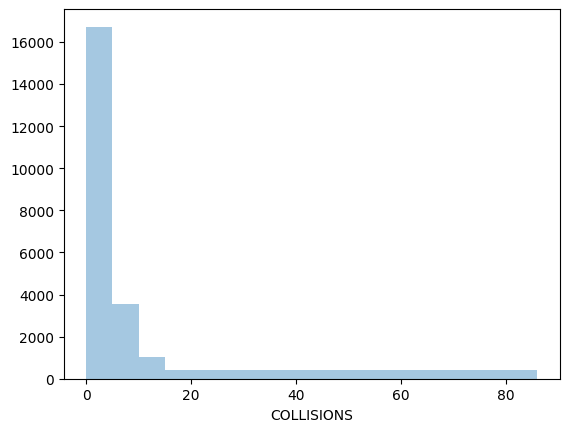

In [ ]:
sns.distplot(df_2012_not_zero['COLLISIONS'], bins=bins, kde=False)

<ipython-input-53-a600bfb343fb>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2013_not_zero['COLLISIONS'], bins=bins, kde=False)


<Axes: xlabel='COLLISIONS'>

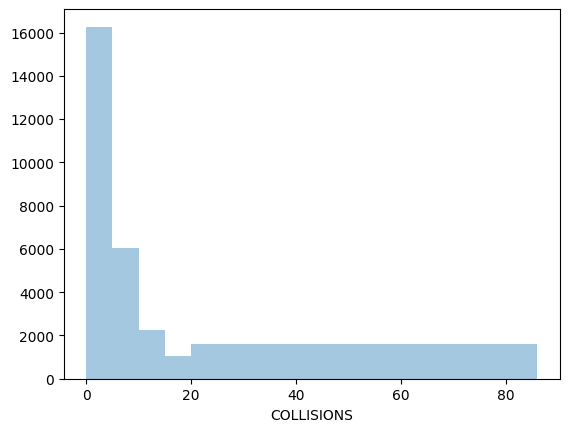

In [ ]:
df_2013 = df[df['YEAR'] == 2013]
df_2013_not_zero = df_2013[df_2013['COLLISIONS'] > 0]
bins = [0,5,10,15,20,86]  # Define the bin edges
sns.distplot(df_2013_not_zero['COLLISIONS'], bins=bins, kde=False)

In [ ]:
df_2013_not_zero['COLLISIONS'].sum()

171933.0

In [ ]:
df_2013_not_zero = df_2013[df_2013['COLLISIONS'] > 0]
df_2013_not_zero

,Unnamed: 0,ST_INDEX,YEAR,COLLISIONS
1,1,0,2013,8.0
49,49,4,2013,7.0
61,61,5,2013,2.0
85,85,7,2013,2.0
241,241,20,2013,17.0
...,...,...,...,...
1452589,1452589,121049,2013,11.0
1452709,1452709,121059,2013,2.0
1453057,1453057,121088,2013,4.0
1453069,1453069,121089,2013,3.0
